In [467]:

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon


import matplotlib.animation as animation 
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


In [468]:
from sqlalchemy import create_engine

ADDR="10.114.22.20"
PORT=55432
USERNAME="postgres"
PASSWORD="postgres"
DBNAME="postgres"

ALGO_NAMES = [
    "dfuzzystream",
    "sfcm",
    "fcm",
    "umicro"
]

ALGORITHM = ALGO_NAMES[3]

PREFIX = "train_with_history_270620"

ALGORITHM_PREFIX_NAME=f"{PREFIX}_{ALGORITHM}"
POINT_TABLE=f"{ALGORITHM_PREFIX_NAME}_points"
CLUSTER_TABLE=f"{ALGORITHM_PREFIX_NAME}_clusters"
PREDICTION_TABLE=f"{ALGORITHM_PREFIX_NAME}_predict"

engine = create_engine(f"postgresql://{USERNAME}:{PASSWORD}@{ADDR}:{PORT}/{DBNAME}")

In [469]:
## Read data
df_origin = pd.read_sql_query(f"""
SELECT {PREDICTION_TABLE}.timestamp, data_point, {PREDICTION_TABLE}.cluster_label, data_point_membership, centroid FROM
              {PREDICTION_TABLE} join {CLUSTER_TABLE}
                  on {PREDICTION_TABLE}.timestamp = {CLUSTER_TABLE}.timestamp and
                     {PREDICTION_TABLE}.cluster_label = {CLUSTER_TABLE}.unique_label""", engine)



In [470]:
df


,timestamp,data_point,cluster_label,data_point_membership,centroid,data_point_unique_id
0,2020-07-08 11:41:12.295,"[1.9934022571715855, 1.277299314215449]",4,1.0,"[2.2921938780207975, -0.46683984297252623]",[1.99340226 1.27729931]
1,2020-07-08 11:41:12.295,"[1.2151951384960422, 1.4749752761954356]",4,1.0,"[2.2921938780207975, -0.46683984297252623]",[1.21519514 1.47497528]
2,2020-07-08 11:41:12.295,"[-1.1964635558545105, 2.0789461412706114]",1,1.0,"[0.0, 0.0]",[-1.19646356 2.07894614]
3,2020-07-08 11:41:12.295,"[-0.43578099042460905, 1.7771155796971694]",3,1.0,"[-1.1964635558545105, 2.0789461412706114]",[-0.43578099 1.77711558]
4,2020-07-08 11:41:12.295,"[0.9786186896549699, 0.5785845564283805]",4,1.0,"[2.2921938780207975, -0.46683984297252623]",[0.97861869 0.57858456]
...,...,...,...,...,...,...
1691,2020-07-08 11:42:02.064,"[-53.999114099092935, 23.525317849949584]",3,1.0,"[-54.41294038752073, 24.610610066296235]",[-53.9991141 23.52531785]
1692,2020-07-08 11:42:02.064,"[-55.16241851490097, 22.322916598672194]",4,1.0,"[-57.1462427088109, 23.39159302766325]",[-55.16241851 22.3229166 ]
1693,2020-07-08 11:42:04.417,"[-12.707601566820044, -57.05059269544629]",2,1.0,"[-15.406896959811373, -59.097880075120436]",[-12.70760157 -57.0505927 ]
1694,2020-07-08 11:42:04.417,"[-12.64052007312682, -56.89917589426065]",2,1.0,"[-15.406896959811373, -59.097880075120436]",[-12.64052007 -56.89917589]


In [471]:
import sys

sys.getsizeof(df) / 1024 /1024

0.5590553283691406

In [472]:
df = df_origin.copy()

In [473]:
#Use timestampts to save results
import datetime
current_time = datetime.date.today()

In [474]:
#transform timestamp from string into correct format
df["timestamp"] = df["timestamp"].apply(lambda x: pd.Timestamp(x))
 
# transform data_point and centroid into numpy arrays
casted_data_points = df["data_point"].apply(lambda x: np.array(x))
df["data_point"] = casted_data_points

# add has for data points
df["data_point_unique_id"] = df["data_point"].apply(str)

casted_centroids = df["centroid"].apply(lambda x: np.array(x))
df["centroid"] = casted_centroids

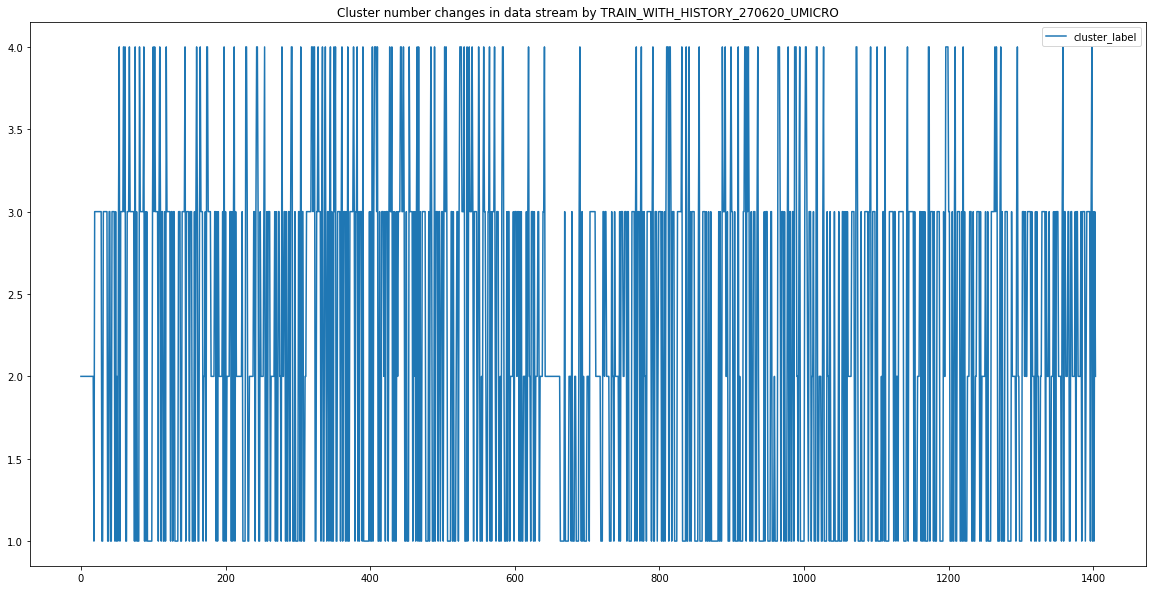

In [475]:
# Changes in number of cluster across time range
df[["cluster_label"]].plot(y="cluster_label", figsize=(20,10), title=f"Cluster number changes in data stream by {ALGORITHM_PREFIX_NAME.upper()}");

plt.savefig(f"images/{ALGORITHM_PREFIX_NAME}_cluster_changes_plot_{current_time}.pdf")
plt.savefig(f"images/{ALGORITHM_PREFIX_NAME}_cluster_changes_plot_{current_time}.png")

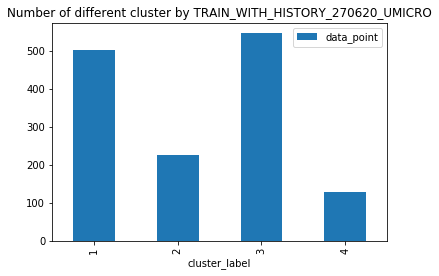

In [476]:
df.groupby("cluster_label").count().plot.bar(y="data_point", title=f"Number of different cluster by {ALGORITHM_PREFIX_NAME.upper()}");


plt.savefig(f"images/{ALGORITHM_PREFIX_NAME}_cluster_number_histogram_{current_time}.pdf")
plt.savefig(f"images/{ALGORITHM_PREFIX_NAME}_cluster_number_histogram_{current_time}.png")

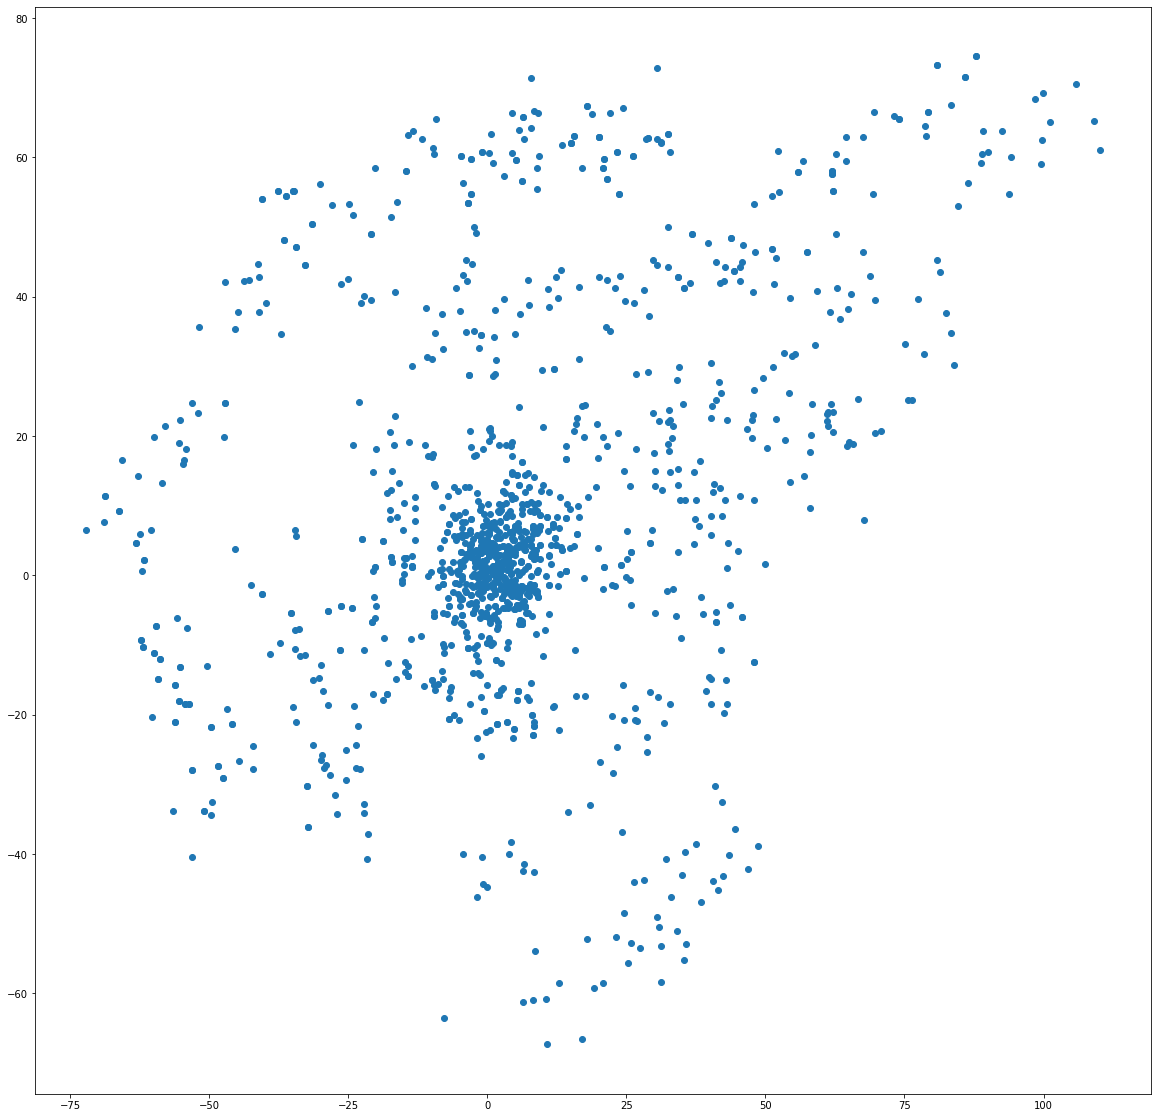

In [477]:
## Draw data points
x = np.stack(df["data_point"])[:,0]
y = np.stack(df["data_point"])[:,1]

plt.figure(figsize=(20,20))
plt.scatter(x,y);


plt.savefig(f"images/{ALGORITHM_PREFIX_NAME}_streaming_data_{current_time}.pdf")
plt.savefig(f"images/{ALGORITHM_PREFIX_NAME}_streaming_data_{current_time}.png")

""


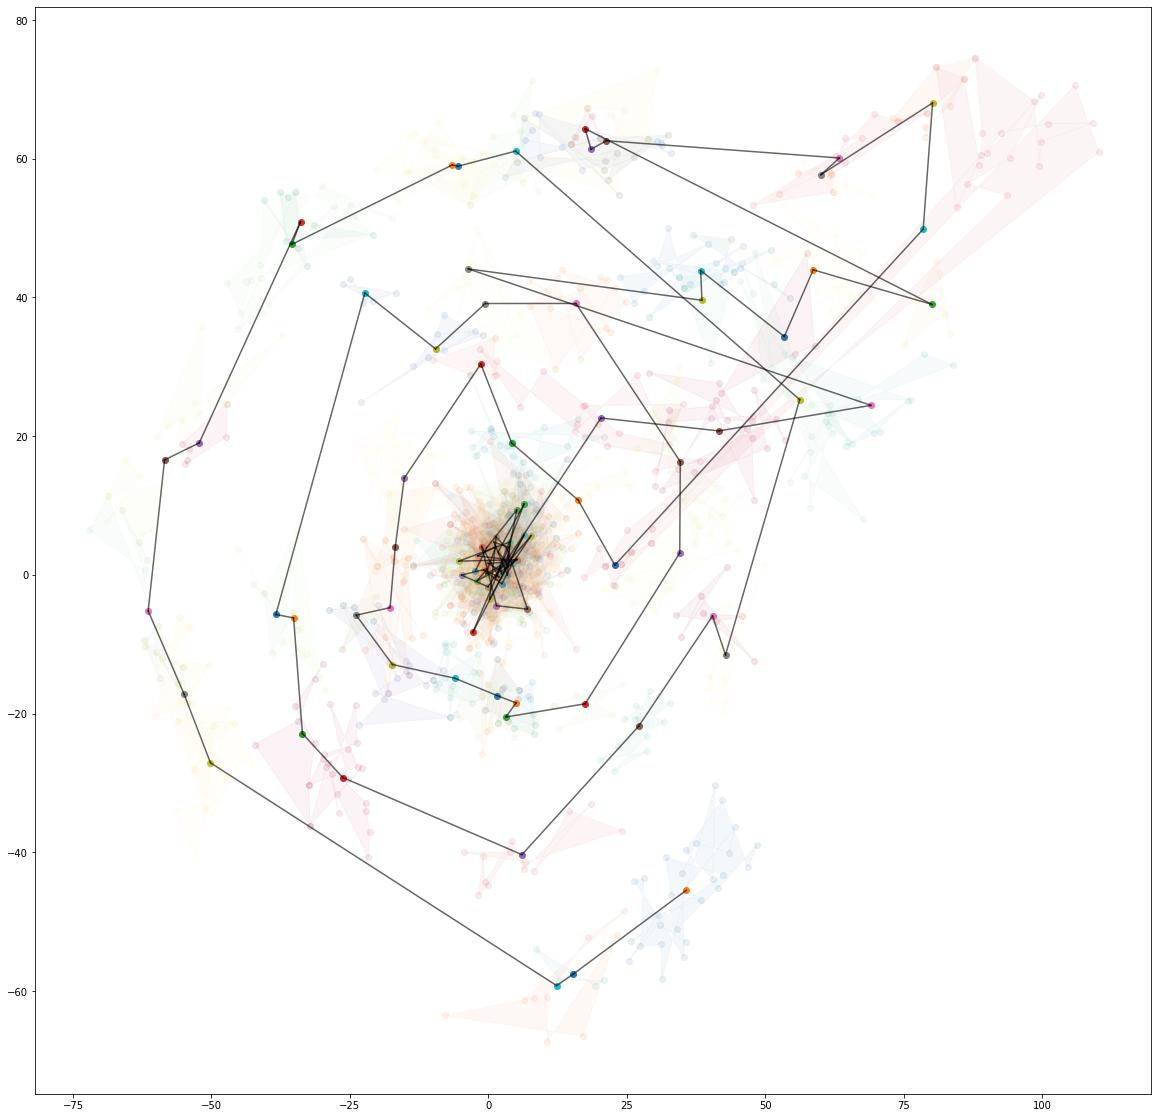

In [478]:

# Draw clusters by processing flow

fig,ax = plt.subplots(figsize=(20,20))
previous_central_point = None

timestamp_enum = dict(map(lambda x: (x[1], x[0]),enumerate(set(df["timestamp"]))))

# Cmap to use
cmap = mpl.cm.get_cmap('Spectral')
time_normalizer = mpl.colors.Normalize(vmin=min(timestamp_enum.values()), vmax=max(timestamp_enum.values()))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=time_normalizer)

def draw_cluster_moving_by_timestamp(df):
    
    current_timestamp = df["timestamp"].min()
    timestamp_color = cmap(time_normalizer(timestamp_enum[current_timestamp]))
    
    centroids = np.stack(df["data_point"])
    
    global previous_central_point
    
    # Find out centroids
    x = centroids[:,0]
    y = centroids[:,1]
    ax.scatter(x,y, alpha=0.1,color=timestamp_color)
    
    polygon = Polygon(centroids,alpha=0.05,zorder=1,color=timestamp_color)
    ax.add_patch(polygon) 
    
    # Find out the "centroids" of centroids
    central_x = np.mean(x)
    central_y = np.mean(y)
    
    ax.scatter(central_x,central_y)
    
    if previous_central_point:
        line_x = np.array([central_x,previous_central_point[0]])
        line_y = np.array([central_y,previous_central_point[1]])
    
        # Draw lines
        ax.plot(line_x, line_y ,alpha=0.6,zorder=10,color="black")
        
        previous_central_point = (central_x,central_y)
    else:
        previous_central_point = (central_x,central_y)
        

df.groupby("timestamp",group_keys=True).apply(draw_cluster_moving_by_timestamp)

In [479]:
# Save fig
fig.savefig(f"images/{ALGORITHM_PREFIX_NAME}_data_points_processing_flow_{current_time}.pdf")
fig.savefig(f"images/{ALGORITHM_PREFIX_NAME}_data_points_processing_flow_{current_time}.png")

In [480]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1404 entries, 0 to 1403
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   timestamp              1404 non-null   datetime64[ns]
 1   data_point             1404 non-null   object        
 2   cluster_label          1404 non-null   int64         
 3   data_point_membership  1404 non-null   float64       
 4   centroid               1404 non-null   object        
 5   data_point_unique_id   1404 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 65.9+ KB


""


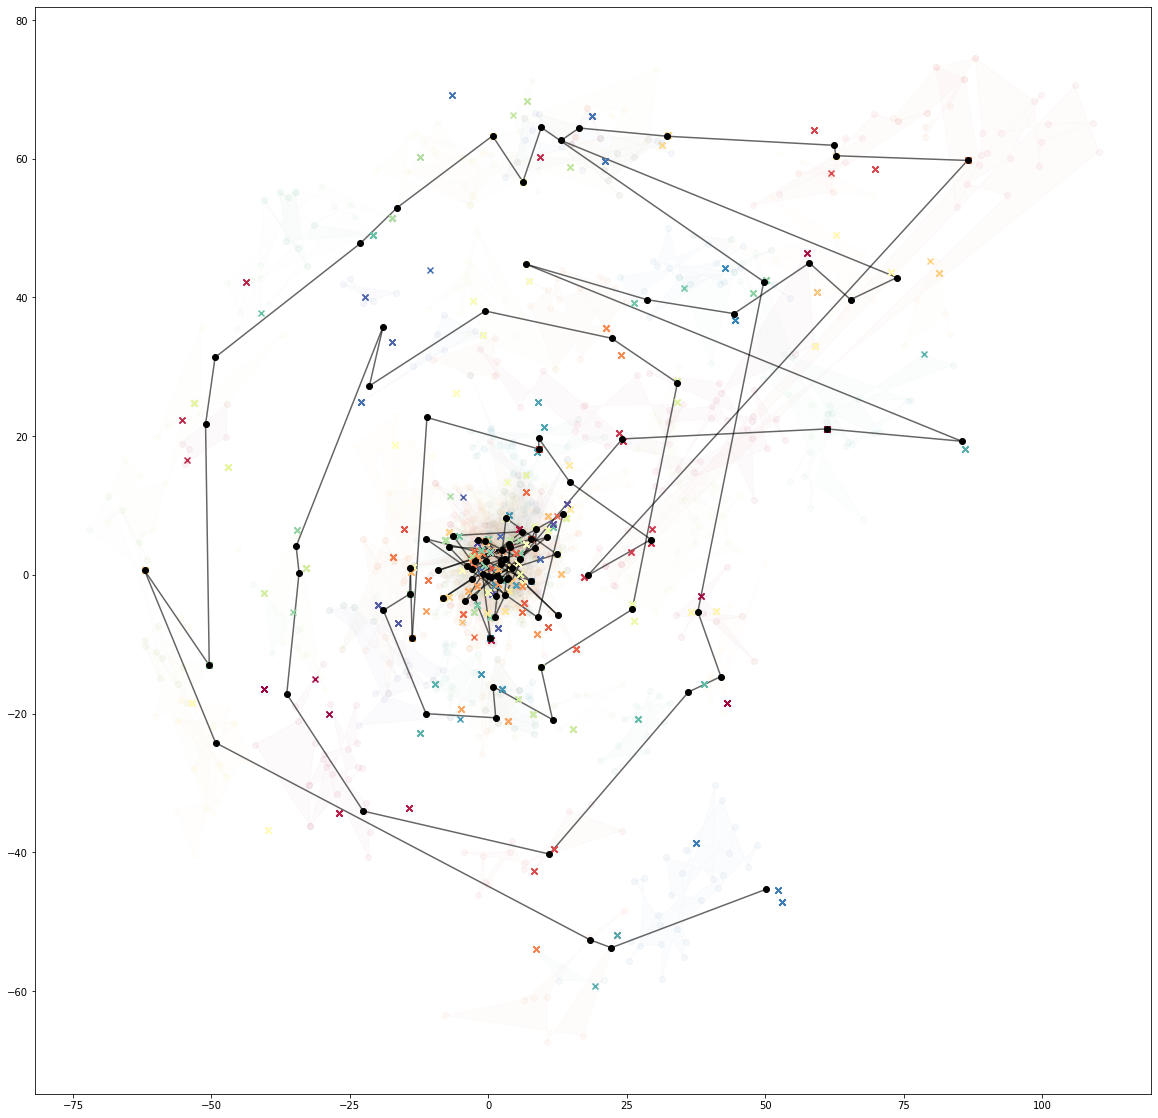

In [481]:
# Draw clusters by timestamps
from matplotlib.pyplot import Polygon


fig, ax = plt.subplots(figsize=(20,20))

timestamp_enum = dict(map(lambda x: (x[1], x[0]),enumerate(set(df["timestamp"]))))
previous_central_point = None

# Cmap to use
cmap = mpl.cm.get_cmap('Spectral')
time_normalizer = mpl.colors.Normalize(vmin=min(timestamp_enum.values()), vmax=max(timestamp_enum.values()))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=time_normalizer)

def draw_clusters_by_timestamp(df):
    
    global previous_central_point
    
    current_timestamp = df["timestamp"].min()
    timestamp_color = cmap(time_normalizer(timestamp_enum[current_timestamp]))
    
    # Possibly add data points
    data_points = np.stack(df["data_point"])
    points_x = data_points[:,0]
    points_y = data_points[:,1]
    
    plt.scatter(points_x,points_y, alpha=0.05, color=timestamp_color)
    
    polygon = Polygon(data_points,alpha=0.02,zorder=1,color=timestamp_color)
    ax.add_patch(polygon) 
    
    centroids = np.stack(df["centroid"].values)
    
    # Find out centroids
    x = centroids[:,0]
    y = centroids[:,1]
    ax.scatter(x,y, marker='x',zorder=15,color=timestamp_color);
    
    # Find out the "centroids" of centroids
    central_x = np.mean(x)
    central_y = np.mean(y)
    ax.scatter(central_x, central_y, c="black",zorder=20)
    
    if previous_central_point:
        line_x = np.array([central_x,previous_central_point[0]])
        line_y = np.array([central_y,previous_central_point[1]])
    
        # Draw lines
        ax.plot(line_x, line_y ,alpha=0.6,zorder=10,color="black")
        
        previous_central_point = (central_x,central_y)
    else:
        previous_central_point = (central_x,central_y)
        
    # Draw links from cluster centroids to a central point for its timestamp
#     for x,y in centroids:
#         line_x = np.array([x,central_x])
#         line_y = np.array([y,central_y])
        
#         # Draw lines
#         ax.plot(line_x, line_y ,alpha=0.05,zorder=10,color=timestamp_color)
                


df.groupby("timestamp").apply(draw_clusters_by_timestamp)



In [482]:
# Save fig
fig.savefig(f"images/{ALGORITHM_PREFIX_NAME}_cluster_processing_flow_{current_time}.pdf")
fig.savefig(f"images/{ALGORITHM_PREFIX_NAME}_cluster_processing_flow_{current_time}.png")

In [483]:
# Aggregate data by timestamp  for further processing    

def process_data_point(df):
    
    point = df["data_point"].values[0]
    clusters = df["centroid"].values
    membership = df["data_point_membership"].values
    return pd.Series(data=dict(point=point,clusters=clusters,membership=membership))
    
    #return point, clusters, membership

r = df.groupby(["timestamp","data_point_unique_id"]).apply(process_data_point)


In [484]:
# Take the first timestamp
first_timestamp = r.xs(r.index[0][0], level="timestamp")

# Several DF to plot

interested_timestamp = [r.xs(r.index[i][0], level="timestamp") for i in range(0,len(r),10)]

#r.loc[r.index[1003][0]]

In [485]:
len(interested_timestamp)

141

In [486]:
# Cmap to use
cmap = mpl.cm.get_cmap('Spectral')
membership_norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=membership_norm)


# Function to print the specific timestamp
def draw_timestamp(datapoints,membership_matrix, cluster_matrix,fig=None,ax=None):
    
    # If no draw layout provided, initialize by itself
    if not ax:
        fig, ax = plt.subplots(figsize=(20,20))
    
    # Data points
    points = np.stack(datapoints)
    membership = np.stack(membership_matrix)
    clusters = np.stack(cluster_matrix)
    
    # For every pair in that timestamp
    for point, pointClusters, membershipCluster in zip(points,clusters, membership):
        
        # Data point coordinates
        point_x = point[0]
        point_y = point[1]
        
        # Gets color for cluster labels
        labels = np.stack(list(map(lambda x: cmap(membership_norm(x)),membershipCluster)))
        
        # Found color for data point
        # depending on the maximum membership it belongs to
        max_membership_index = np.argmax(membershipCluster)
        point_color = labels[max_membership_index]
        
        # Draw point
        ax.scatter(point_x,point_y, color=point_color,zorder=0)
        
        
        # Clusters and its membership
        for i, (cluster, membership, label) in enumerate(sorted(zip(pointClusters, membershipCluster,labels), key=lambda row: row[1])):
            
                # Cluster coordinates
                cluster_x = cluster[0]
                cluster_y = cluster[1]
        
                # Membership lines
                line_x = np.array([cluster_x,point_x])
                line_y = np.array([cluster_y,point_y])
                
                
                # Draw lines
                ax.plot(line_x,line_y, alpha=membership,
                        # color=label,
                        zorder=10)
                # Draw clusters
                ax.scatter(cluster_x,cluster_y,marker='x',
                           #color=label,
                           zorder=50)
                
    
def apply_drawing(dfs,fig=None,ax=None):
    
   
    for df in dfs:
        points = df["point"].values
        clusters = np.stack(df["clusters"].values)
        membership = np.stack(df["membership"].values)
        
        # If no draw layout provided, initialize by itself
        if not ax or not fig:
            fig, ax = plt.subplots(figsize=(20,20))
    
        draw_timestamp(points, membership, clusters,fig,ax)
        
    plt.colorbar(sm)
    

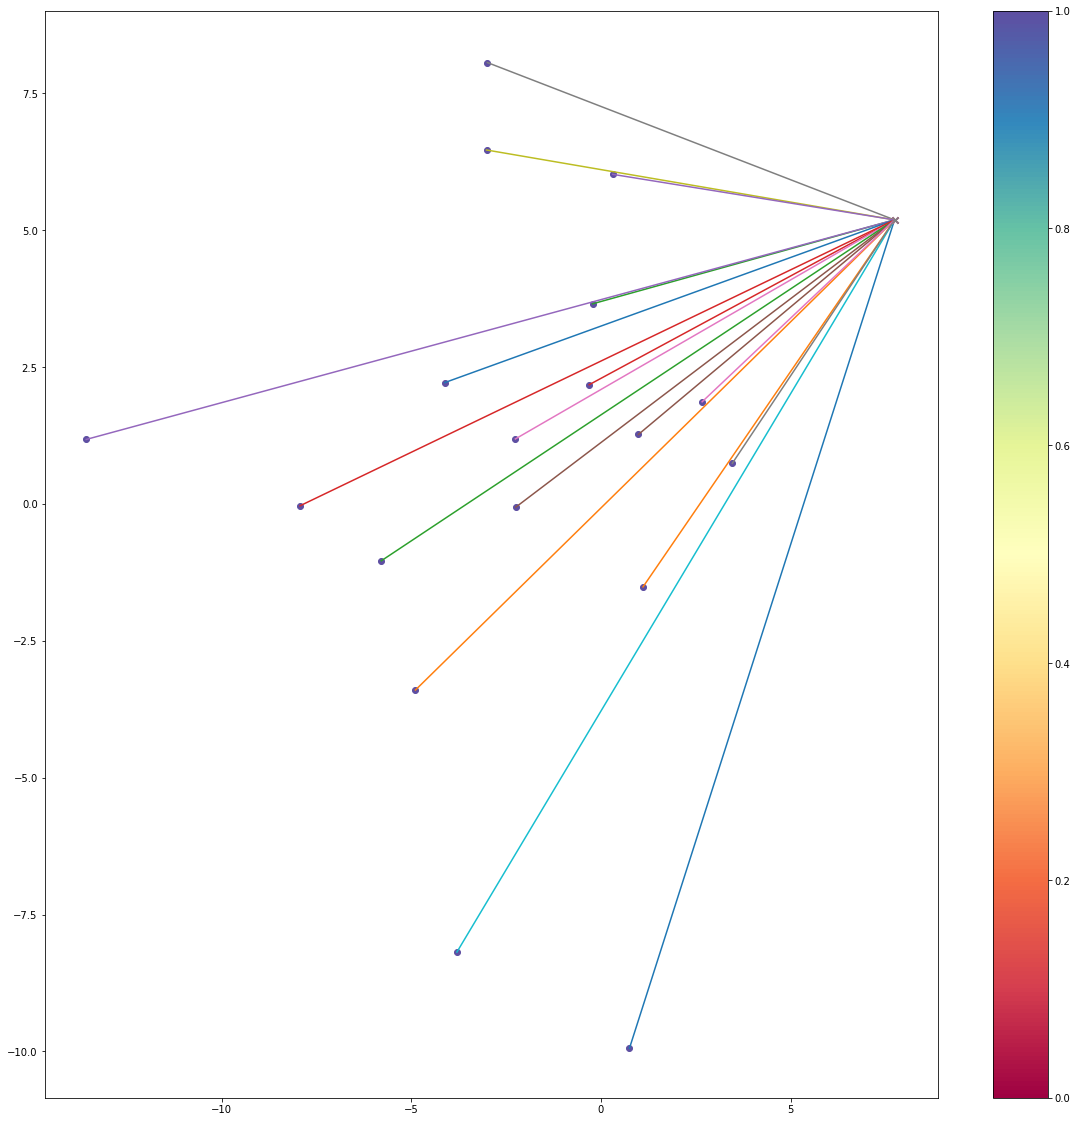

In [487]:

    
fig, ax = plt.subplots(figsize=(20,20))
    
apply_drawing([first_timestamp,],fig,ax)


In [488]:

# Save figure 

fig.savefig(f"images/{ALGORITHM_PREFIX_NAME}_first_timestamp_{current_time}.pdf")
fig.savefig(f"images/{ALGORITHM_PREFIX_NAME}_first_timestamp_{current_time}.png")

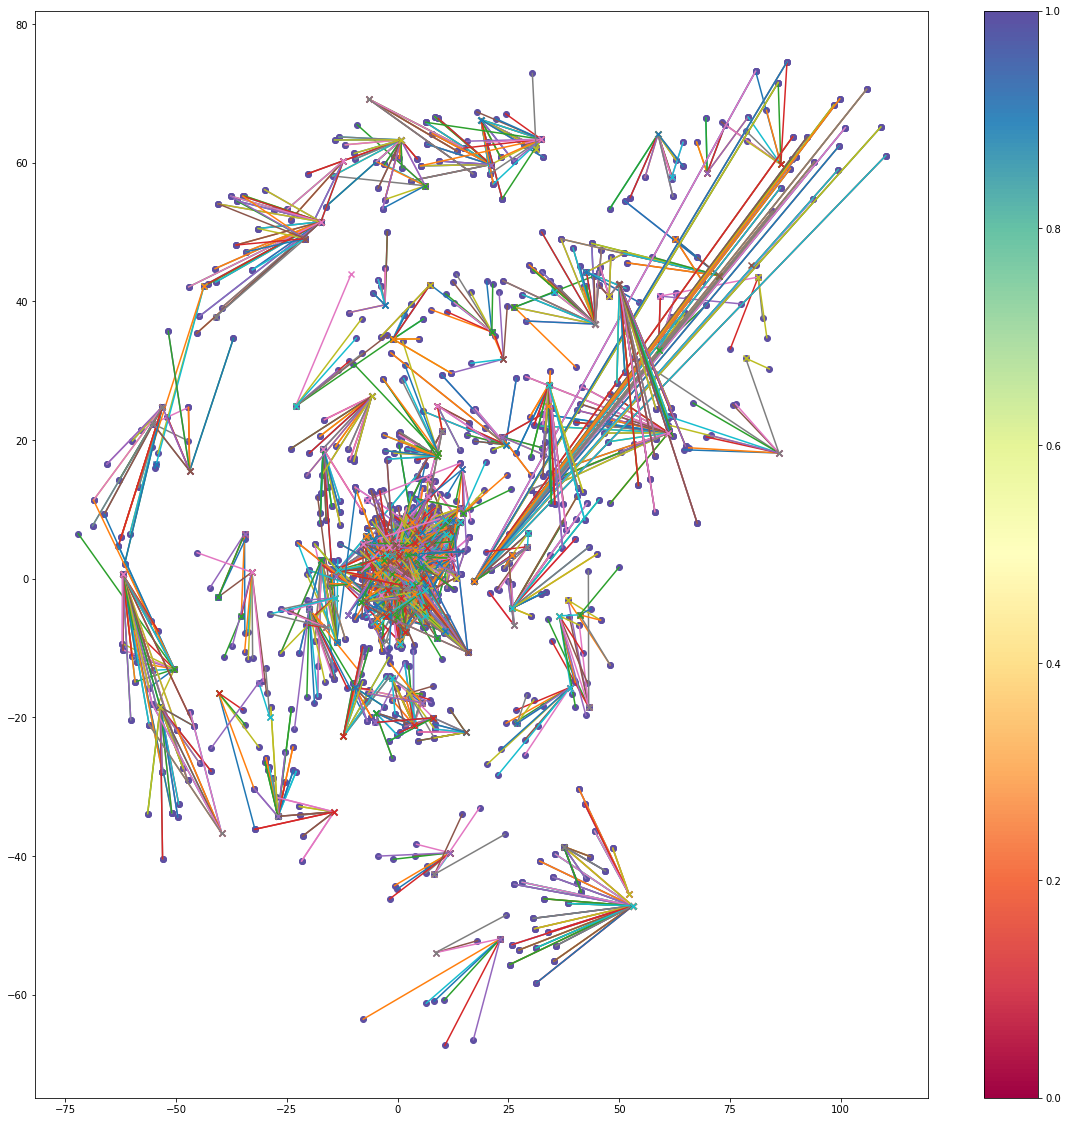

In [489]:
# Let's apply drawing on several timestamps

fig, ax = plt.subplots(figsize=(20,20))

apply_drawing(interested_timestamp,fig,ax)



In [490]:
fig.savefig(f"images/{ALGORITHM_PREFIX_NAME}_several_timestamp.png")